# Introduction to Text Analysis in Python

I am not an NLP person and this is outside of my expertise, but I know enough to give a basic introduction to text analysis and text processing tools.

For this tutorial + homework, I'm going to use data from Reddit. I'm getting it from PushShift, using the following code. You can run this yoursel to get your own dataset (e.g., from different subreddits, or different dates). I'd recommend, however, just using the dataset that I created. I show how to import it below

In [1]:
import requests
from datetime import datetime
import pprint
import time
import pandas as pd
import seaborn as sns

In [ ]:
## Code used to create the dataset - no need to run this code

endpt = 'https://api.pushshift.io/reddit/search/submission'

subreddits = ['AskReddit','Coronavirus', 'politics']

# Start and end date (pushshift expects these in epoch time)
start_date = int(datetime.strptime('2020-03-11', '%Y-%m-%d').timestamp())
end_date = int(datetime.strptime('2020-03-25', '%Y-%m-%d').timestamp())


def get_posts(subreddit, before = end_date, after = start_date, result = None,  min_comments = 20):
    params = {'subreddit': subreddit,
              'num_comments': f'>{min_comments}',
              'before': before,
              'size': 500
             }
    if result == None:
        result = []
    r = requests.get(endpt, params=params)
    print(r.url)
    print(datetime.fromtimestamp(before))
    for item in r.json()['data']:
        created_time = item['created_utc']
        if created_time < after: # If we've reached the earliest we want, then return
            print(len(result))
            return result
        else:
            try:
                result.append((item['title'],item['selftext'], created_time, subreddit))
            except KeyError:
                print(item)
    time.sleep(.5)
    return get_posts(subreddit, before = created_time, result = result)


sr_data = []
for subreddit in subreddits:
    new_data = get_posts(subreddit)
    sr_data = sr_data + new_data
sr = pd.DataFrame(sr_data, columns = ['title', 'selftext', 'date', 'subreddit'])
sr.date = pd.to_datetime(sr.date, unit='s')
sr.to_csv('./sr_post_data.csv', index = False)

In [2]:
## Code to download and import the file (DO run this code)
import matplotlib.pyplot as plt
import pandas as pd

sr = pd.read_csv('https://github.com/jdfoote/Intro-to-Programming-and-Data-Science/blob/master/resources/data/sr_post_data.csv?raw=true')


In [3]:
# Change the date to a datetime, and put it in the index
sr.index = pd.to_datetime(sr.date)

In [14]:
sr.head()

,title,selftext,date,subreddit,num_posts
date,,,,,
2020-03-25 03:58:28,What’s your least favorite color? Why?,NaN,2020-03-25 03:58:28,AskReddit,1
2020-03-25 03:57:58,What was the reason for the last time you cried?,NaN,2020-03-25 03:57:58,AskReddit,1
2020-03-25 03:57:17,What are songs that have to be played full bla...,NaN,2020-03-25 03:57:17,AskReddit,1
2020-03-25 03:55:50,How to get rid of excessive amounts of anger a...,NaN,2020-03-25 03:55:50,AskReddit,1
2020-03-25 03:51:49,What's your go to fantasy?,NaN,2020-03-25 03:51:49,AskReddit,1


## Summarization

There are some simple ways to summarize text data that can be useful, without using any special NLP tools.


For example, it can be very interesting to see how the frequency of a term changes over time:

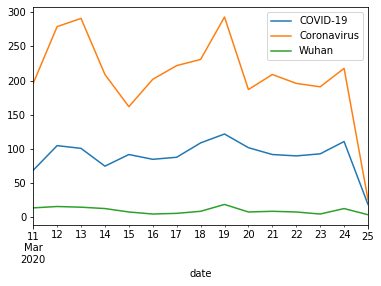

In [4]:
# This code plots the frequency of "COVID-19", "Coronavirus", and "Wuhan" each day
sr['num_posts'] = 1 # As in earlier visualization, just tells us each row represents 1 post

for term in ["COVID-19", "Coronavirus", "Wuhan"]:
    curr_df = sr.loc[sr.title.str.contains(term) | sr.selftext.str.contains(term)]
    posts_per_day = curr_df.resample('D').num_posts.sum()
    posts_per_day.plot(label = term)

plt.legend()
plt.show()

### EXERCISE

Modify the code above to plot how often "Coronavirus" is used in each of the three subreddits over time

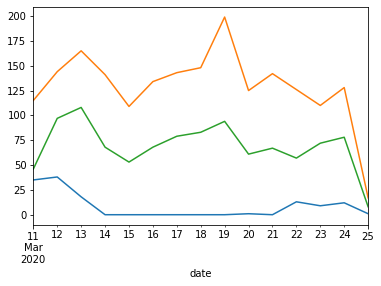

In [17]:
sr['num_posts'] = 1
sr.loc[(pd.isna(sr.selftext)) | (sr.selftext.isin(['[removed]', '[deleted]'])), 'selftext'] = ''
sr['all_text'] = sr.title + ' ' + sr.selftext

askreddit = sr.loc[sr.subreddit.str.contains('AskReddit') & sr.all_text.str.contains("Coronavirus")]
corona = sr.loc[sr.subreddit.str.contains('Coronavirus') & sr.all_text.str.contains("Coronavirus")]
politics = sr.loc[sr.subreddit.str.contains('politics')  & sr.all_text.str.contains("Coronavirus")]
for df in [askreddit, corona, politics]:
    posts_per_day = df.resample('D').num_posts.sum()
    posts_per_day.plot()
    

A similar approach is dictionary-based. The most well-known version of this is [LIWC](http://liwc.wpengine.com/), but the basic idea is that you create a set of words that are associated with a construct you are interested in, and you count how often they appear.

This is a very simple example of how you might do this to look for gendered words among our subreddits

In [15]:
# First we change NAs and removed/deleted to empty strings
sr.loc[(pd.isna(sr.selftext)) | (sr.selftext.isin(['[removed]', '[deleted]'])), 'selftext'] = ''
sr['all_text'] = sr.title + ' ' + sr.selftext

In [16]:
sr.head()

,title,selftext,date,subreddit,num_posts,all_text
date,,,,,,
2020-03-25 03:58:28,What’s your least favorite color? Why?,,2020-03-25 03:58:28,AskReddit,1,What’s your least favorite color? Why?
2020-03-25 03:57:58,What was the reason for the last time you cried?,,2020-03-25 03:57:58,AskReddit,1,What was the reason for the last time you cried?
2020-03-25 03:57:17,What are songs that have to be played full bla...,,2020-03-25 03:57:17,AskReddit,1,What are songs that have to be played full bla...
2020-03-25 03:55:50,How to get rid of excessive amounts of anger a...,,2020-03-25 03:55:50,AskReddit,1,How to get rid of excessive amounts of anger a...
2020-03-25 03:51:49,What's your go to fantasy?,,2020-03-25 03:51:49,AskReddit,1,What's your go to fantasy?


In [6]:
male_words = ['he', 'his']
female_words = ['she', 'hers']
# This puts all of the text of each subreddit into lists
grouped_text = sr.groupby('subreddit').all_text.apply(lambda x: ' '.join(x).split())
print(grouped_text)
# Then, we count how often each type of words appears in each subreddit
agg = grouped_text.aggregate({'proportion2': lambda x: sum([x.count(y) for y in male_words])/len(x),
                        'proportion1': lambda x: sum([x.count(y) for y in female_words])/len(x)}
                        )
agg

subreddit
AskReddit      [What’s, your, least, favorite, color?, Why?, ...
Coronavirus    [America, in, triage:, Are, we, ready, to, reo...
politics       [Trump's, DC, Hotel, Promises, a, “HUGE, Celeb...
Name: all_text, dtype: object


             subreddit  
proportion2  AskReddit      0.000858
             Coronavirus    0.001704
             politics       0.005122
proportion1  AskReddit      0.000199
             Coronavirus    0.000253
             politics       0.000126
Name: all_text, dtype: float64

### EXERCISES

1. One of the trickiest parts of analysis is getting the data in the form that you want it in order to analyze/visualize it. 

I think a good visualization for this would be a barplot showing how often male and female word types appear for each subreddit. I'll give you the final call to produce the plot:

`sns.barplot(x='subreddit', y='proportion', hue = 'word_gender', data = agg_df)`

Now, see if you can get the data in shape so that this code actually works! :)

*Hint: You'll want to use [wide to long](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.wide_to_long.html)*

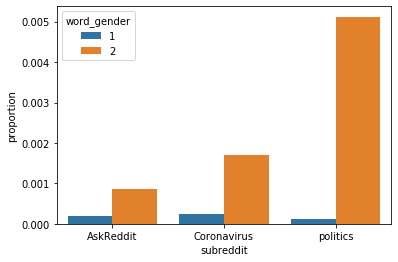

In [13]:
## This code will get the df ready for pd.wide_to_long (try printing agg_df after running these to see what it looks like)
agg_df = agg.unstack(level=0)
agg_df = agg_df.reset_index()
agg_df = pd.wide_to_long(agg_df, stubnames = "proportion", i="subreddit", j="word_gender")
agg_df = agg_df.reset_index()


sns.barplot(x='subreddit', y='proportion', hue = 'word_gender', data = agg_df)

2. Make your own analysis, with a different set of terms

In [ ]:

endpt = 'https://api.pushshift.io/reddit/search/submission'

subreddits = ['alexa']

# Start and end date (pushshift expects these in epoch time)
start_date = int(datetime.strptime('2018-01-01', '%Y-%m-%d').timestamp())
end_date = int(datetime.strptime('2020-03-25', '%Y-%m-%d').timestamp())


def get_posts(subreddit, before = end_date, after = start_date, result = None,  min_comments = 20):
    params = {'subreddit': subreddit,
              'num_comments': f'>{min_comments}',
              'before': before,
              'size': 500
             }
    if result == None:
        result = []
    r = requests.get(endpt, params=params)
    print(r.url)
    print(datetime.fromtimestamp(before))
    for item in r.json()['data']:
        created_time = item['created_utc']
        if created_time < after: # If we've reached the earliest we want, then return
            print(len(result))
            return result
        else:
            try:
                result.append((item['title'],item['selftext'], created_time, subreddit))
            except KeyError:
                print(item)
    time.sleep(.5)
    return get_posts(subreddit, before = created_time, result = result)


alexa_data = []
for subreddit in subreddits:
    alexa_data = get_posts(subreddit)
alexa = pd.DataFrame(alexa_data, columns = ['title', 'selftext', 'date', 'subreddit'])
alexa.date = pd.to_datetime(alexa.date, unit='s')
alexa.to_csv('./alexa_post_data.csv', index = False)

In [15]:
alexa_df = pd.read_csv('./alexa_post_data.csv')
alexa_df.loc[(pd.isna(alexa_df.selftext)) | (alexa_df.selftext.isin(['[removed]', '[deleted]'])), 'selftext'] = ''
alexa_df['all_text'] = alexa_df.title + ' ' + alexa_df.selftext
alexa_df

,title,selftext,date,subreddit,all_text
0,New device alert: Wyze Band,For $25 I’m either thinking this is incredibly...,2020-03-24 17:07:42,alexa,New device alert: Wyze Band For $25 I’m either...
1,My first try at motorizing cheap Walmart rolle...,,2020-03-19 01:21:34,alexa,My first try at motorizing cheap Walmart rolle...
2,Echo show finally automatically will show a li...,,2020-03-17 06:11:42,alexa,Echo show finally automatically will show a li...
3,Alexa should allow ‘AND’ed smart home commands.,This: “Alexa: turn off kitchen AND dining room...,2020-03-11 22:27:43,alexa,Alexa should allow ‘AND’ed smart home commands...
4,Smart switch recommendations?,,2020-03-10 01:38:06,alexa,Smart switch recommendations?
...,...,...,...,...,...
214,Alexa has become hard of hearing lately.,Several months ago when I first gone an echo a...,2018-02-12 06:53:19,alexa,Alexa has become hard of hearing lately. Sever...
215,Alexa should have a Polite Mode for kids (and ...,Must say please and thank you.\nMust ask in po...,2018-02-02 17:55:58,alexa,Alexa should have a Polite Mode for kids (and ...
216,Tell Alexa to “ask the listeners.” It’s insane...,Update: say “hey guys” once you’re talking to ...,2018-02-02 02:25:42,alexa,Tell Alexa to “ask the listeners.” It’s insane...
217,How are you using your wifi outlet with Alexa?,"We were given one, but I have no idea what to ...",2018-01-26 23:38:14,alexa,How are you using your wifi outlet with Alexa?...


In [29]:
alexa_df['num_posts'] = 1
alexa_df.index = pd.to_datetime(alexa_df.date)
print(alexa_df)



for term in ['firetv cube', 'echo', 'dot', 'show', 'alexa']:
    alexa_interest_df = alexa_df.loc[alexa_df.all_text.str.contains(term)]
    print(alexa_interest_df)
    alexa_interest_df = alexa_interest_df.reset_index(drop=True)
    print(alexa_interest_df)
    posts_per_month = alexa_interest_df.resample('m').num_posts.sum()
    print(posts_per_month)
    posts_per_month.plot(label = term)

plt.legend()
plt.show()

                                                                 title  \
date                                                                     
2020-03-24 17:07:42                        New device alert: Wyze Band   
2020-03-19 01:21:34  My first try at motorizing cheap Walmart rolle...   
2020-03-17 06:11:42  Echo show finally automatically will show a li...   
2020-03-11 22:27:43    Alexa should allow ‘AND’ed smart home commands.   
2020-03-10 01:38:06                      Smart switch recommendations?   
...                                                                ...   
2018-02-12 06:53:19           Alexa has become hard of hearing lately.   
2018-02-02 17:55:58  Alexa should have a Polite Mode for kids (and ...   
2018-02-02 02:25:42  Tell Alexa to “ask the listeners.” It’s insane...   
2018-01-26 23:38:14     How are you using your wifi outlet with Alexa?   
2018-01-16 20:25:49  If you could get Amazon to fix / change just o...   

                                     

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

## TF-IDF

There are more complicated approaches to summarization in Python, including using LIWC (see [here](https://pypi.org/project/liwc/)).

Almost all approaches are based on a "bag of words" approach, where the order of words is totally ignored. This is obviously a big simplification, but can often work quite well.

One thing we might want to do is to differentiate groups of texts based on how often words are used. The naive way is to just count how often words appear. However, the most common words will always appear first. So, computational linguists came up with "term frequency--inverse document frequency" (TF-IDF). This normalizes words based on how often they appear across groups of texts. A detailed explanation with code is [here](https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76).

There are a number of NLP / text analysis libraries in Python. The one I'm most familiar with is scikit-learn, which is a machine learning library. NLTK, SpaCy, and textblob are some of the most popular. Here is how to run TF-IDF in scikit-learn.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Just gets the 5000 most common words
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

as_text = [' '.join(x) for x in grouped_text]

tfidf_result = vectorizer.fit_transform(as_text)
feature_names = vectorizer.get_feature_names()
dense = tfidf_result.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names).transpose()
df.columns = ['AskReddit','Coronavirus', 'politics']

NameError: name 'grouped_text' is not defined

In [ ]:
# This shows the values with the highest TF-IDF for r/Coronavirus
df.sort_values('politics', ascending=False).head(20)

## Classification

Another commonly-used tool in NLP is classification. This is a "supervised machine learning" model, where you build a "training set" of items that are classified, and a machine learner uses that set to predict the classification of new items.

One very common example is sentiment. In sentiment analysis, a random set of texts is manually classified as positive, neutral, or negative. This set is then used to train a classifier to predict the sentiment of unseen texts.

It's beyond the scope of this class to learn how to do machine learning, but there are also pre-trained classifiers. One I found is from [textblob](https://textblob.readthedocs.io/en/dev/).

NLTK also has a pre-trained classifier, trained on social media data, called VADER. That is pretty similar to what we're looking at, so this example shows how to use it.

NLTK is interesting - the core is installed in Anaconda, so you should have it. However, to get various pieces to work you need to install them. So, we need to start by installing the vader lexicon.

In [ ]:
import nltk
nltk.downloader.download('vader_lexicon')

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(sentence):
    vs = analyzer.polarity_scores(sentence)
    return vs['compound']

sr['sentiment'] = sr.all_text.apply(get_sentiment)

In [ ]:
sr.sort_values('sentiment', ascending=False).head()

## Topic Modeling

Finally, I'm going to show an example of topic modeling.

This is complicated, both mathematically and in code. I'm pulling this example from [my book chapter](https://communitydata.science/social-media-chapter/), which was itself based on [this example](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py).

The basic idea of topic modeling is that you are trying to optimize the likelihood of a set of distributions of words over topics and topics over documents based on the documents that actually exist. The idea is that each document can be seen as being generated by a mix of topics, and we try to find the set of topics that best matches. This works best on a large set of documents, which are themselves each quite large. Today we're making the mistake of using it on a small number of documents. I've made the opposite mistake before of using it on something like tweets. It works OK-ish in both of these circumstances, but it isn't ideal.

In [ ]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import sys
import csv
import pandas as pd
import argparse

"""
This code was inspired/copied from http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html.

It takes in a list of documents and creates two outputs:
1. The documents together with their topic distribution and 
2. A set of topics and the top words associated with each.
"""


def run_lda(dataset, 
            n_topics = 10,     # How many topics to produce
            n_features = 20000 # How many different n-grams to consider (uses the most common)
           ):


    print("Loading dataset...")
    t0 = time()
    print("done in %0.3fs." % (time() - t0))

    # Use tf (raw term count) features for LDA.
    print("Extracting tf features for LDA...")
    tf_vectorizer = CountVectorizer(max_df=0.95, # Terms that show up in > max_df of documents are ignored
                                    #min_df=2, # Terms that show up in < min_df of documents are ignored
                                    max_features=n_features, # Only use the top max_features 
                                    stop_words='english',
                                    ngram_range=(1,2))
    t0 = time()
    tf = tf_vectorizer.fit_transform(dataset)
    print("done in %0.3fs." % (time() - t0))


    print("Fitting LDA models with tf features, "
          "n_samples=%d and n_features=%d..."
          % (len(dataset), n_features))
    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=2017,
                                    n_jobs=2)
    t0 = time()
    model = lda.fit(tf)
    transformed_model = lda.fit_transform(tf)
    print("done in %0.3fs." % (time() - t0))


    # Change the values into a probability distribution for each document
    topic_dist = [[topic/sum(topics) 
                   for topic in topics]
                          for topics in transformed_model]

    # Make the topic distribution into a dataframe
    td = pd.DataFrame(topic_dist)
    # Get the feature names (i.e., the words/terms)
    tf_feature_names = tf_vectorizer.get_feature_names()


    # Get the top words by topic
    topic_words = get_top_words(lda, tf_feature_names, 20)
    # Sort by how often topic is used
    topic_words = topic_words.reindex(sorted(topic_words.columns, 
                                             key = lambda x: td[x].sum(), 
                                             reverse=True),axis=1)

    # Rearrange the columns by how often each topic is used
    td = td.reindex(sorted(td.columns, 
                           key = lambda x: td[x].sum(), 
                           reverse=True),
                    axis=1)
    
    print('Topics by how common each topic is:')
    print(topic_words)
    print('Distributions of topic for each subreddit')
    print(td)
    


def get_top_words(model, feature_names, n_top_words):
    '''Takes the model, the words used, and the number of words requested.
    Returns a dataframe of the top n_top_words for each topic'''
    r = pd.DataFrame()
    # For each topic
    for i, topic in enumerate(model.components_):
        # Get the top feature names, and put them in that column
        r[i] = [add_quotes(feature_names[i])
                    for i in topic.argsort()[:-n_top_words - 1:-1]]
    return r

def add_quotes(s):
    '''Adds quotes around multiple term phrases'''
    if " " in s:
        s =  '"{}"'.format(s)
    return s

## Version 1

This version treats all of the text from a subreddit as a single document, and compares subreddits.

In [ ]:
# Gets all of the strings for each subreddit and combines them into one long string for
# that subreddit
dataset = []
for s in grouped_text:
    dataset.append(' '.join(s))

# Takes that list of "documents" and runs LDA on it
run_lda(dataset)

## Version 2

This version tries to look at the range of topics from the Coronavirus subreddit. It takes all of the different posts from just the Coronavirus subreddit and treats each one as a document. In this case, the problem is that they are almost all short (they are typically headlines of articles that are shared).

In [ ]:
dataset = sr.loc[sr.subreddit == 'Coronavirus', 'all_text']
run_lda(dataset)

I think that this is quite a bit better and you can start to see some patterns and topics emerging.

### EXERCISE

Where topic modeling really shines is in analyzing longer texts - for example, the subreddit [changemyview](https://www.reddit.com/r/changemyview/) has fairly long posts where people explain a controversial view that they hold.

Try to figure out how to get the posts from changemyview, and run a topic model on them, where the selftext of each post is a document.

In [ ]:
endpt = 'https://api.pushshift.io/reddit/search/submission'

subreddits = ['changemyview']

# Start and end date (pushshift expects these in epoch time)
start_date = int(datetime.strptime('2020-03-11', '%Y-%m-%d').timestamp())
end_date = int(datetime.strptime('2020-06-25', '%Y-%m-%d').timestamp())


def get_posts(subreddit, before = end_date, after = start_date, result = None,  min_comments = 20):
    params = {'subreddit': subreddit,
              'num_comments': f'>{min_comments}',
              'before': before,
              'size': 500
             }
    if result == None:
        result = []
    r = requests.get(endpt, params=params)
    print(r.url)
    print(datetime.fromtimestamp(before))
    for item in r.json()['data']:
        created_time = item['created_utc']
        if created_time < after: # If we've reached the earliest we want, then return
            print(len(result))
            return result
        else:
            try:
                result.append((item['title'],item['selftext'], created_time, subreddit))
            except KeyError:
                print(item)
    time.sleep(.5)
    return get_posts(subreddit, before = created_time, result = result)


sr_data = []
for subreddit in subreddits:
    new_data = get_posts(subreddit)
    sr_data = sr_data + new_data
sr = pd.DataFrame(sr_data, columns = ['title', 'selftext', 'date', 'subreddit'])
sr.date = pd.to_datetime(sr.date, unit='s')
sr.to_csv('./sr_post_data.csv', index = False)

In [ ]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import sys
import csv
import pandas as pd
import argparse

changemyview_df = pd.read_csv('./sr_post_data.csv')
changemyview_df.loc[(pd.isna(changemyview_df.selftext)) | (changemyview_df.selftext.isin(['[removed]', '[deleted]'])), 'selftext'] = ''


In [ ]:
dataset = []
for s in changemyview_df.selftext:
    dataset.append(s)

run_lda(dataset)

In [35]:
alexa_interest_df

,title,selftext,date,subreddit,num_posts
date,,,,,
